In [1]:
import numpy as np
import pandas as pd

import pygmo as pg

from uda import ES, EP
from scipy.optimize import minimize

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib notebook

import math
from matplotlib.colors import LogNorm

In [2]:
font = {'family' : 'serif',
        'weight' : 'medium',
        'size'   : 14}

plt.rc('font', **font)
plt.rcParams['axes.facecolor'] = 'white'

In [3]:
%load_ext line_profiler

In [4]:
funcs = [1, 2, 6, 7, 9, 14]
dimensions = [2, 10, 30]
POP_SIZE = 20
N_RUNS = 51

## CMAES/xNES/DE

In [5]:
results = []

for nx in dimensions:
    for func in funcs:
        generations = nx * 10000 // POP_SIZE - 1
        
        prob = pg.problem(pg.cec2014(prob_id=func, dim=nx))
        algo = pg.algorithm(pg.cmaes(gen=generations, ftol=1e-9, xtol=1e-9, memory=True))
        archi = pg.archipelago(N_RUNS, algo=algo, prob=prob, pop_size=POP_SIZE)
        archi.evolve(1)
        archi.wait()
        
        champions = [isl.get_population().champion_f[0] for isl in archi]
        evals = [isl.get_population().problem.get_fevals() for isl in archi]
        for run, properties in enumerate(zip(champions, evals)):
            result = {
                         "algo": "CMA-ES",
                         "function": func,
                         "dimensions": nx,
                         "run": run,
                         "champion_f": properties[0],
                         "evals": properties[1]
                     }
            
            results.append(result)


for nx in dimensions:
    for func in funcs:
        generations = nx * 10000 // POP_SIZE - 1
        
        prob = pg.problem(pg.cec2014(prob_id=func, dim=nx))
        algo = pg.algorithm(pg.xnes(gen=generations, ftol=1e-9, xtol=1e-9, memory=True))
        archi = pg.archipelago(N_RUNS, algo=algo, prob=prob, pop_size=POP_SIZE)
        archi.evolve(1)
        archi.wait()
        
        champions = [isl.get_population().champion_f[0] for isl in archi]
        evals = [isl.get_population().problem.get_fevals() for isl in archi]
        for run, properties in enumerate(zip(champions, evals)):
            result = {
                         "algo": "xNES",
                         "function": func,
                         "dimensions": nx,
                         "run": run,
                         "champion_f": properties[0],
                         "evals": properties[1]
                     }
            
            results.append(result)

            
for nx in dimensions:
    for func in funcs:
        max_generations = nx * 10000 // POP_SIZE - 1
        evolution_generations = int(max_generations * 0.95)
        memetic_generations = max_generations - evolution_generations
        
        prob = pg.problem(pg.cec2014(prob_id=func, dim=nx))
        algo = pg.algorithm(pg.xnes(gen=evolution_generations, ftol=1e-9, xtol=1e-9, memory=True))
        archi = pg.archipelago(N_RUNS, algo=algo, prob=prob, pop_size=POP_SIZE)
        archi.evolve(1)
        archi.wait()
        
        
        def opt_fun(x):
            return prob.fitness(x)[0]
        
        champions = []
        for isl in archi:
            champion = isl.get_population().champion_x
            res = minimize(opt_fun, champion, method='Nelder-Mead', tol=1e-9, options={'maxfev': memetic_generations,
                                                                                       'xatol': 1e-9,
                                                                                       'fatol': 1e-9})

            champions.append(res.fun)
        
        evals = [isl.get_population().problem.get_fevals() for isl in archi]
        
        for run, properties in enumerate(zip(champions, evals)):
            result = {
                         "algo": "xNES - Memetico",
                         "function": func,
                         "dimensions": nx,
                         "run": run,
                         "champion_f": properties[0],
                         "evals": properties[1]
                     }
            
            results.append(result)
            
results = pd.DataFrame(results, columns=["function", "dimensions", "algo", "run", "champion_f", "evals"])
results["error"] = results["champion_f"] - (results["function"] * 100)
results["success"] = results["error"] < 1e-8

## Parameter Search

In [5]:
population_sizes = [8, 13, 21, 34]
etas_a = [3.3e-03, 2e-02, 3.3e-02, 1e-01]
funcs = [1, 2, 6, 7, 9, 14]
dimensions = [10, 30]
POP_SIZE = 20
N_RUNS = 8

funcs = [1]
dimensions = [2]

In [18]:
results = []

for pop_size in population_sizes:
    for eta_a in etas_a:
        for nx in dimensions:
            for func in funcs:
                generations = nx * 10000 // pop_size - 1

                prob = pg.problem(pg.cec2014(prob_id=func, dim=nx))
                algo = pg.algorithm(pg.xnes(gen=generations, eta_sigma=eta_a, eta_b=eta_a,
                                            ftol=1e-9, xtol=1e-9, memory=True))
                algo.set_verbosity(1)
                archi = pg.archipelago(N_RUNS, algo=algo, prob=prob, pop_size=pop_size)
                archi.evolve(1)
                archi.wait()

                champions = [isl.get_population().champion_f[0] for isl in archi]
                evals = [isl.get_population().problem.get_fevals() for isl in archi]
                for run, properties in enumerate(zip(champions, evals)):
                    result = {
                                 "algo": "xNES",
                                 "function": func,
                                 "dimensions": nx,
                                 "run": run,
                                 "champion_f": properties[0],
                                 "evals": properties[1],
                                 "eta_a": eta_a,
                                 "pop_size": pop_size
                             }

                    results.append(result)


results = pd.DataFrame(results, columns=["function", "dimensions", "algo", "run",
                                         "champion_f", "evals", "eta_a", "pop_size"])
results["error"] = results["champion_f"] - (results["function"] * 100)
results["success"] = results["error"] < 1e-8

In [21]:
tmp = archi[0].get_population().problem
tmp.extract(pg.xnes).get_log()

AttributeError: 'NoneType' object has no attribute 'get_log'

In [7]:
results.groupby(["algo", "function", "dimensions", "eta_a", "pop_size"]).mean()

run    champion_f       evals  \
algo function dimensions eta_a  pop_size                                  
xNES 1        10         0.0033 8         3.5  3.065815e+02  100000.000   
                                13        3.5  8.639030e+03   99996.000   
                                21        3.5  1.762769e+05   99981.000   
                                34        3.5  1.553825e+06   99994.000   
                         0.0200 8         3.5  1.000000e+02   52242.000   
                                13        3.5  1.000000e+02   71604.000   
                                21        3.5  1.000000e+02   99981.000   
                                34        3.5  1.000003e+02   99994.000   
                         0.0330 8         3.5  1.000000e+02   32308.000   
                                13        3.5  1.000000e+02   44066.750   
                                21        3.5  1.000000e+02   63855.750   
                                34        3.5  1.000000e+02   96322.000   
                         0.1000 8         3.5  1.000000e+02   11757.000   
                                13        3.5  1.000000e+02   15406.625   
                                21        3.5  1.000000e+02   21695.625   
                                34        3.5  1.000000e+02   32257.500   
              30         0.0033 8         3.5  1.019464e+02  300000.000   
                                13        3.5  2.495241e+02  299988.000   
                                21        3.5  1.241361e+04  299985.000   
                                34        3.5  4.027946e+05  299982.000   
                         0.0200 8         3.5  1.000000e+02  114823.000   
                                13        3.5  1.000000e+02  140580.375   
                                21        3.5  1.000000e+02  190585.500   
                                34        3.5  1.000000e+02  273819.000   
                         0.0330 8         3.5  9.468979e+04  190059.000   
                                13        3.5  1.000000e+02   88762.375   
                                21        3.5  1.000000e+02  117875.625   
                                34        3.5  1.000000e+02  169052.250   
                         0.1000 8         3.5  2.245847e+08  300000.000   
                                13        3.5  7.328832e+06  299988.000   
...                                       ...           ...         ...   
     14       10         0.0033 21        3.5  1.400240e+03   99981.000   
                                34        3.5  1.400287e+03   99994.000   
                         0.0200 8         3.5  1.400397e+03   65985.000   
                                13        3.5  1.400377e+03   84708.000   
                                21        3.5  1.400342e+03   99981.000   
                                34        3.5  1.400288e+03   99994.000   
                         0.0330 8         3.5  1.400364e+03   47354.000   
                                13        3.5  1.400386e+03   52841.750   
                                21        3.5  1.400366e+03   73019.625   
                                34        3.5  1.400324e+03   99994.000   
                         0.1000 8         3.5  1.400433e+03   59387.000   
                                13        3.5  1.400385e+03   18786.625   
                                21        3.5  1.400423e+03   25738.125   
                                34        3.5  1.400363e+03   37714.500   
              30         0.0033 8         3.5  1.400274e+03  300000.000   
                                13        3.5  1.400291e+03  299988.000   
                                21        3.5  1.400301e+03  299985.000   
                                34        3.5  1.400286e+03  299982.000   
                         0.0200 8         3.5  1.400360e+03  300000.000   
                                13        3.5  1.400333e+03  299988.000   
                                21        3.5  1.400500e+03  299985

In [8]:
results.groupby(["algo", "function", "dimensions", "eta_a", "pop_size"]).median()

run    champion_f     evals  \
algo function dimensions eta_a  pop_size                                
xNES 1        10         0.0033 8         3.5  2.962459e+02  100000.0   
                                13        3.5  8.621346e+03   99996.0   
                                21        3.5  1.762432e+05   99981.0   
                                34        3.5  1.523000e+06   99994.0   
                         0.0200 8         3.5  1.000000e+02   52312.0   
                                13        3.5  1.000000e+02   71903.0   
                                21        3.5  1.000000e+02   99981.0   
                                34        3.5  1.000003e+02   99994.0   
                         0.0330 8         3.5  1.000000e+02   32324.0   
                                13        3.5  1.000000e+02   44109.0   
                                21        3.5  1.000000e+02   63882.0   
                                34        3.5  1.000000e+02   96322.0   
                         0.1000 8         3.5  1.000000e+02   11788.0   
                                13        3.5  1.000000e+02   15353.0   
                                21        3.5  1.000000e+02   21630.0   
                                34        3.5  1.000000e+02   32232.0   
              30         0.0033 8         3.5  1.019787e+02  300000.0   
                                13        3.5  2.507369e+02  299988.0   
                                21        3.5  1.243067e+04  299985.0   
                                34        3.5  4.018154e+05  299982.0   
                         0.0200 8         3.5  1.000000e+02  114884.0   
                                13        3.5  1.000000e+02  140491.0   
                                21        3.5  1.000000e+02  190554.0   
                                34        3.5  1.000000e+02  273819.0   
                         0.0330 8         3.5  3.039554e+02  190540.0   
                                13        3.5  1.000000e+02   88744.5   
                                21        3.5  1.000000e+02  118009.5   
                                34        3.5  1.000000e+02  169014.0   
                         0.1000 8         3.5  2.118513e+08  300000.0   
                                13        3.5  7.278334e+06  299988.0   
...                                       ...           ...       ...   
     14       10         0.0033 21        3.5  1.400229e+03   99981.0   
                                34        3.5  1.400296e+03   99994.0   
                         0.0200 8         3.5  1.400406e+03   65864.0   
                                13        3.5  1.400374e+03   84565.0   
                                21        3.5  1.400376e+03   99981.0   
                                34        3.5  1.400287e+03   99994.0   
                         0.0330 8         3.5  1.400369e+03   40036.0   
                                13        3.5  1.400386e+03   53027.0   
                                21        3.5  1.400370e+03   72943.5   
                                34        3.5  1.400330e+03   99994.0   
                         0.1000 8         3.5  1.400433e+03   47256.0   
                                13        3.5  1.400382e+03   18765.5   
                                21        3.5  1.400441e+03   25756.5   
                                34        3.5  1.400383e+03   37638.0   
              30         0.0033 8         3.5  1.400274e+03  300000.0   
                                13        3.5  1.400291e+03  299988.0   
                                21        3.5  1.400294e+03  299985.0   
                                34        3.5  1.400291e+03  299982.0   
                         0.0200 8         3.5  1.400345e+03  300000.0   
                                13        3.5  1.400335e+03  299988.0   
                                21        3.5  1.400500e+03  299985.0   
                                34        3.5  1.400381e+03  299982.0   
                         0.

In [75]:
np.logspace?

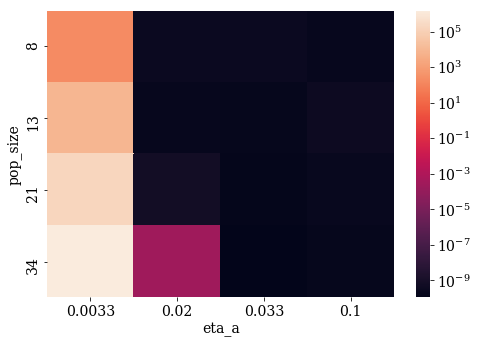

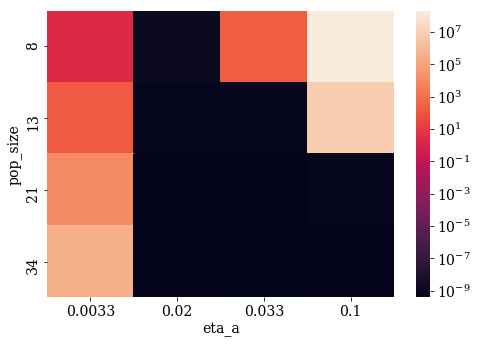

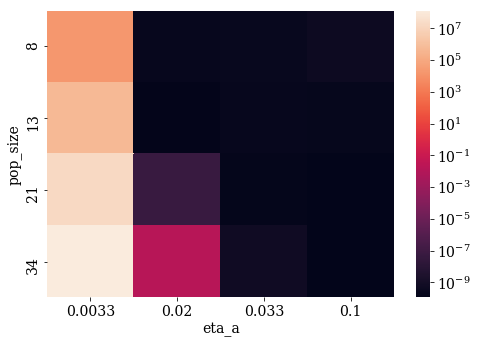

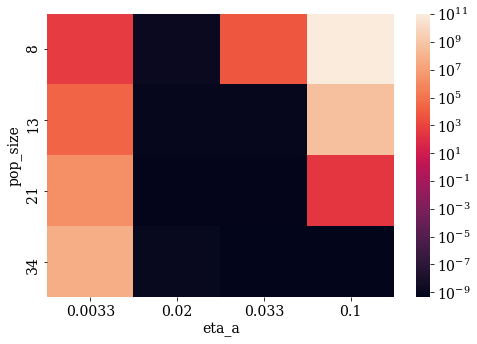

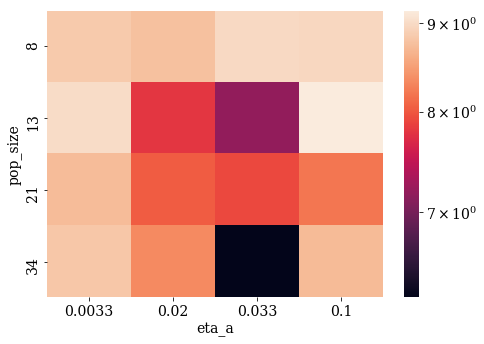

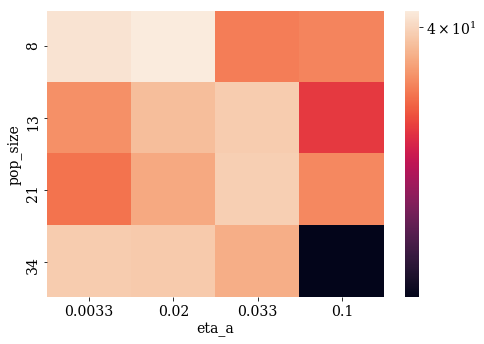

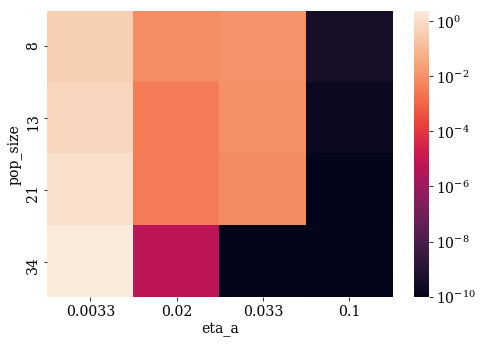

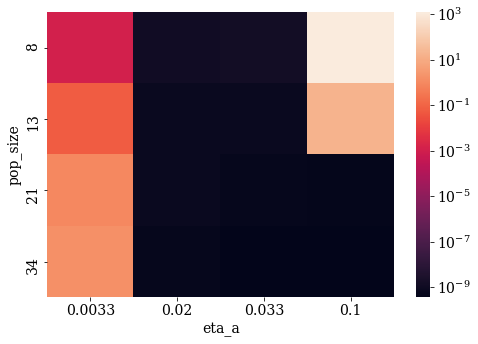

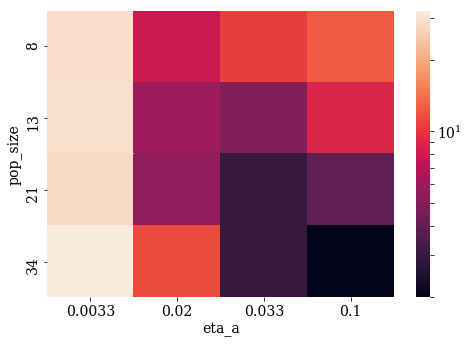

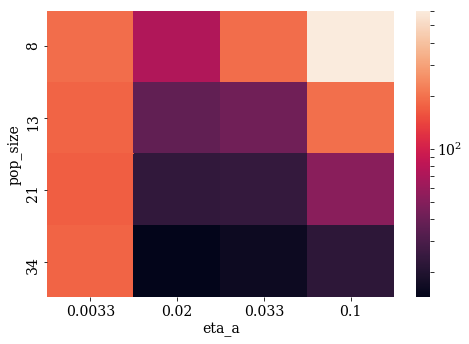

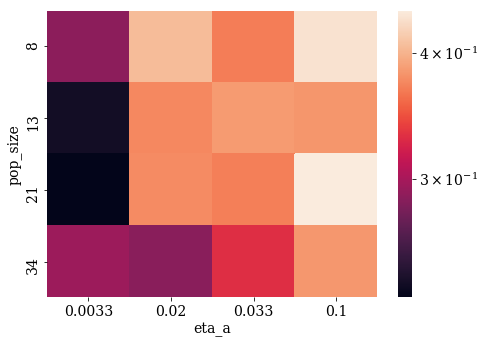

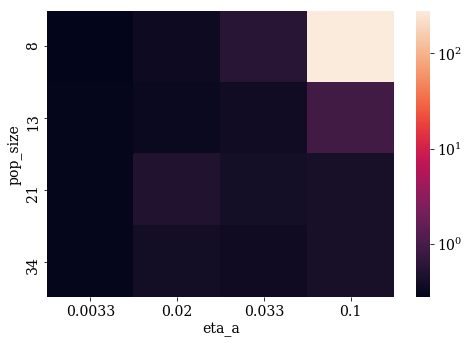

In [122]:
for func in funcs:
    for dim in dimensions:
        error_median = results.loc[(results.function == func) & (results.dimensions == dim), :]\
                              .groupby(["eta_a", "pop_size"]).median()["error"]
        error_median = pd.DataFrame(error_median.to_frame().to_records()).pivot("pop_size", "eta_a", "error")

        vmin, vmax = error_median.min().min(), error_median.max().max()
        log_norm = LogNorm(vmin=vmin, vmax=vmax)
        cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(vmin)),
                                                     1+math.ceil(math.log10(vmax)))]
        if len(cbar_ticks) > 5:
            cbar_ticks = [v for k, v in enumerate(cbar_ticks) if k % 2]
        if len(cbar_ticks) < 4:
            cbar_ticks = None
            
        if vmax < 3 * vmin:
            pass
            
        plt.figure(figsize=(7,5))
        ax = sns.heatmap(error_median, norm=log_norm, cbar_kws={"ticks": cbar_ticks})
        plt.tight_layout()
        plt.savefig(f"hiperparams/function={func:02d}_dim={dim:02d}")

In [95]:
results.groupby(["eta_a", "pop_size"]).std()["success"]

eta_a   pop_size
0.0033  8           0.000000
        13          0.000000
        21          0.000000
        34          0.000000
0.0200  8           0.497251
        13          0.500876
        21          0.486664
        34          0.435286
0.0330  8           0.456916
        13          0.497251
        21          0.499890
        34          0.502188
0.1000  8           0.422503
        13          0.422503
        21          0.493710
        34          0.502625
Name: success, dtype: float64

### Results Analysis

In [6]:
results = []

for pop_size in population_sizes:
    for eta_a in etas_a:
        for nx in dimensions:
            for func in funcs:
                generations = nx * 10000 // pop_size - 1

                prob = pg.problem(pg.cec2014(prob_id=func, dim=nx))
                algo = pg.algorithm(pg.xnes(gen=generations, eta_sigma=eta_a, eta_b=eta_a,
                                            ftol=1e-9, xtol=1e-9, memory=True))
                archi = pg.archipelago(N_RUNS, algo=algo, prob=prob, pop_size=pop_size)
                archi.evolve(1)
                archi.wait()

                champions = [isl.get_population().champion_f[0] for isl in archi]
                evals = [isl.get_population().problem.get_fevals() for isl in archi]
                for run, properties in enumerate(zip(champions, evals)):
                    result = {
                                 "algo": "xNES",
                                 "function": func,
                                 "dimensions": nx,
                                 "run": run,
                                 "champion_f": properties[0],
                                 "evals": properties[1],
                                 "eta_a": eta_a,
                                 "pop_size": pop_size
                             }

                    results.append(result)

"""
for nx in dimensions:
    for func in funcs:
        generations = nx * 10000 // POP_SIZE - 1
        
        prob = pg.problem(pg.cec2014(prob_id=func, dim=nx))
        algo = pg.algorithm(pg.cmaes(gen=generations, ftol=1e-9, xtol=1e-9, memory=True))
        archi = pg.archipelago(N_RUNS, algo=algo, prob=prob, pop_size=POP_SIZE)
        archi.evolve(1)
        archi.wait()
        
        champions = [isl.get_population().champion_f[0] for isl in archi]
        evals = [isl.get_population().problem.get_fevals() for isl in archi]
        for run, properties in enumerate(zip(champions, evals)):
            result = {
                         "algo": "CMA-ES",
                         "function": func,
                         "dimensions": nx,
                         "run": run,
                         "champion_f": properties[0],
                         "evals": properties[1]
                     }
            
            results.append(result)
"""


results = pd.DataFrame(results, columns=["function", "dimensions", "algo", "run",
                                         "champion_f", "evals", "eta_a", "pop_size"])
results["error"] = results["champion_f"] - (results["function"] * 100)
results["success"] = results["error"] < 1e-8

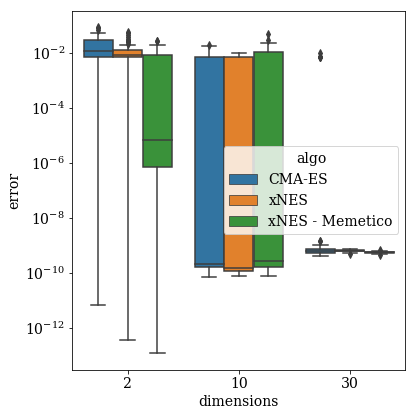

In [13]:
plt.figure(figsize=(6,6))
ax = sns.boxplot(data=results.loc[results.function == 7, :], x="dimensions", y="error", hue="algo")
plt.yscale('log')
#plt.ylim((10**-14, 10**2))
plt.tight_layout()
plt.show()

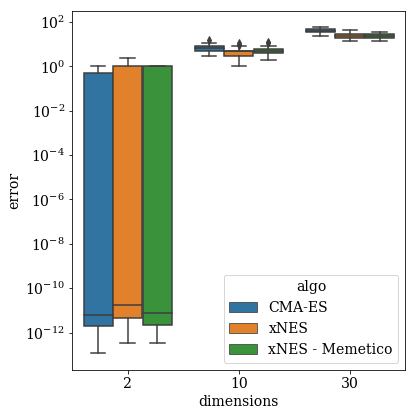

In [12]:
plt.figure(figsize=(6,6))
ax = sns.boxplot(data=results.loc[results.function == 9, :], x="dimensions", y="error", hue="algo")
plt.yscale('log')
#plt.ylim((10**-14, 10**2))
plt.tight_layout()
plt.show()

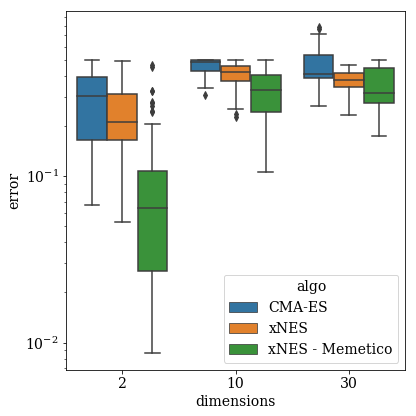

In [10]:
plt.figure(figsize=(6,6))
ax = sns.boxplot(data=results.loc[results.function == 14, :], x="dimensions", y="error", hue="algo")
plt.yscale('log')
#plt.ylim((10**-14, 10**2))
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


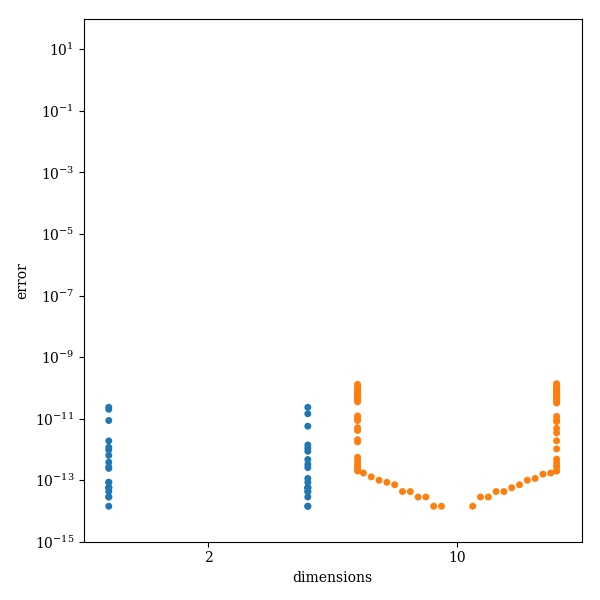

In [16]:
plt.figure(figsize=(6,6))
ax = sns.swarmplot(x=results.loc[results.function == 1, "dimensions"], y=results.loc[results.function == 1, "error"])
plt.yscale('log')
plt.ylim((10**-15, 10**2))
plt.tight_layout()
plt.show()

## Debug

### Algo

In [8]:
prob = pg.problem(pg.cec2014(prob_id=1, dim=2))
algo = ES(memory=True)
pop = pg.population(prob=prob, size=POP_SIZE)

In [9]:
%lprun -f algo.evolve algo.evolve(pop)

In [11]:
for _ in range(10):
    #print(pop.champion_f[0])
    print(pop.get_f()[:, 0].mean())
    algo.evolve(pop)

6787.639164846338
6517.004330737569
3911.1722927743176
3817.269752746578
12643.944862216365
7281.807480712583
5739.149739969055
8012.224507580415
3988.823754646437
5662.45915878652


### Island

In [12]:
prob = pg.problem(pg.cec2014(prob_id=1, dim=2))
algo = ES(memory=True)
isl = pg.island(algo=algo, prob=prob, size=POP_SIZE)

In [13]:
print(isl.get_population().champion_f[0])
isl.evolve(10)
isl.wait()
print(isl.get_population().champion_f[0])

96308580.35220265
2811.8345166483887
